In [19]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Dataset Read


In [9]:
LABELS = ["PNEUMONIA", "NORMAL"]
img_size = 150

def get_training_data(data_dir: str):
    images = []
    labels = []
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)
        for img in os.listdir(path):
            if not img.endswith(".jpeg"):
                continue
            try:
                img_arr = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Failed to load image: {img}")
                    continue
                resized_arr = cv.resize(img_arr, (img_size, img_size))
                images.append(resized_arr)
                labels.append(class_num)
            except Exception as e:
                print(e)
    return np.array(images), np.array(labels)

In [10]:
train_data_dir=r"E:\pr_ai_NTI\chest_xray\train"
teste_data_dir=r"E:\pr_ai_NTI\chest_xray\test"
validation_data_dir=r"E:\pr_ai_NTI\chest_xray\val"

x_train, y_train = get_training_data(train_data_dir)
x_test, y_test = get_training_data(teste_data_dir)
x_val, y_val = get_training_data(validation_data_dir)



# Data Visualization

C:\Users\yahay\AppData\Local\Temp\ipykernel_16956\1830745542.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df_train, palette="Blues")


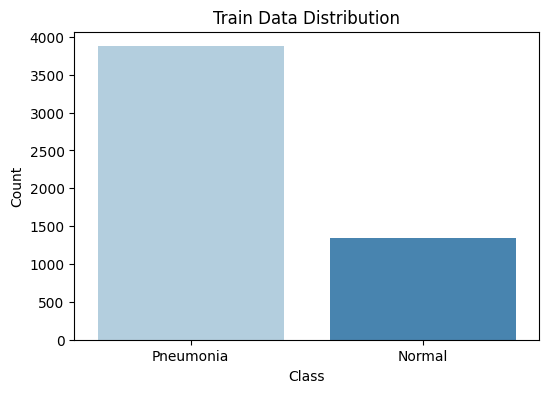

In [11]:
l = []
for i in y_train:
    if(i == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

df_train = pd.DataFrame({'Label': l})

plt.figure(figsize=(6,4))

sns.countplot(x='Label', data=df_train, palette="Blues")
plt.title("Train Data Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()   

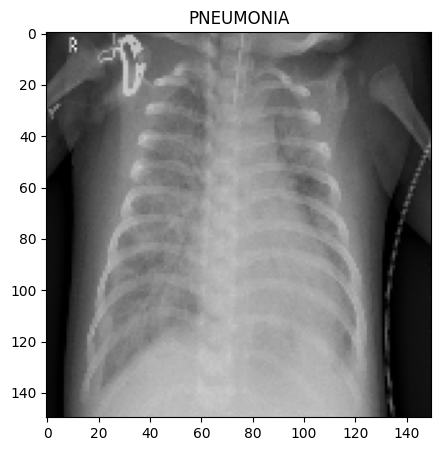

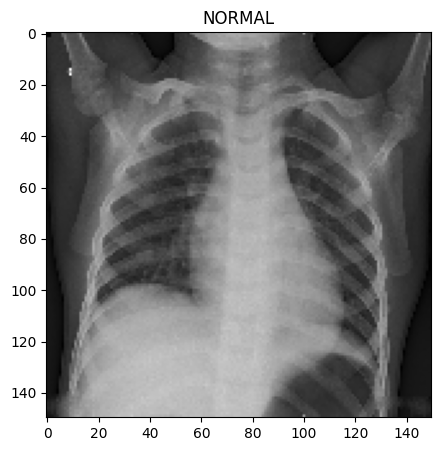

In [13]:
la = ['PNEUMONIA', 'NORMAL']

plt.figure(figsize=(5,5))
plt.imshow(x_train[0], cmap='gray')
plt.title(la[y_train[0]])   
plt.show()


plt.figure(figsize=(5,5))
plt.imshow(x_train[-1], cmap='gray')
plt.title(la[y_train[-1]])  
plt.show()



#  Data Preprocessing & Augmentation



In [14]:
x_train = np.array(x_train) / 255
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = np.array(x_test) / 255
x_test = x_test.reshape(-1, img_size,img_size, 1)
y_test = np.array(y_test)

x_val = np.array(x_val) / 255
x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [15]:
train_datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.2,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
)


  

np.random.seed(42)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32
    )





# Training the Model

In [ ]:
model = Sequential(
    [
        Conv2D(
            32,
            (3, 3),
            strides=1,
            padding="same",
            activation="relu",
            input_shape=(150, 150, 1),
        ),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        
        Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"),
        Dropout(0.1),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        
        Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        
        Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"),
        Dropout(0.2),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        
        Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"),
        Dropout(0.2),
        BatchNormalization(),
        MaxPool2D((2, 2), strides=2, padding="same"),
        
        Flatten(),
        Dense(units=128, activation="relu"),
        Dropout(0.2),
        Dense(units=1, activation="sigmoid"),
    ]
)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


c:\Users\yahay\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)



reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1,
    min_delta=0.000001)

In [21]:
history = model.fit(
   train_generator ,
    epochs=20,
    validation_data=train_datagen.flow(x_val, y_val),
    callbacks=[early_stopping,reduce_lr],
)

c:\Users\yahay\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.8230 - loss: 0.7845 - val_accuracy: 0.5000 - val_loss: 7.3200 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.9154 - loss: 0.2247 - val_accuracy: 0.5000 - val_loss: 11.8977 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9306 - loss: 0.1793 - val_accuracy: 0.5000 - val_loss: 6.3905 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9335 - loss: 0.1701 - val_accuracy: 0.5000 - val_loss: 4.3846 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9377 - loss: 0.1603 - val_accuracy: 0.6250 - val_loss: 1.1049 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9365 - loss: 0.1782 - val_accuracy: 0.5000 - val_loss: 8.4652 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9444 - loss: 0

In [22]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.8436 - loss: 0.3595
Loss of the model is -  0.32868990302085876
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.8436 - loss: 0.3595
Accuracy of the model is -  85.41666865348816 %


In [27]:
predictions = model.predict(x_test)
y_predictions= np.array([1 if prob > 0.5 else 0 for prob in predictions.flatten()])
y_predictions[:15]


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

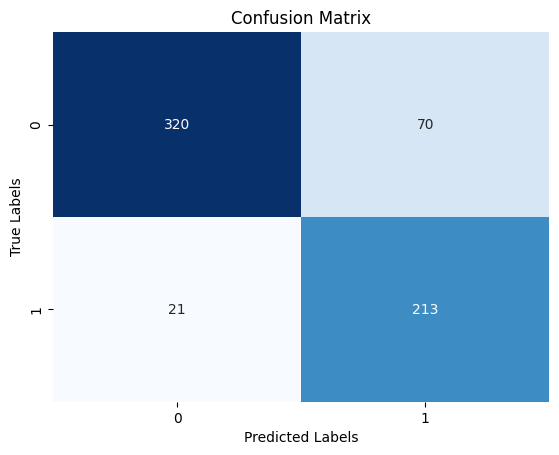

In [28]:
cm = confusion_matrix(y_test, y_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
print(classification_report(y_test, y_predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.82      0.88       390
   Normal (Class 1)       0.75      0.91      0.82       234

           accuracy                           0.85       624
          macro avg       0.85      0.87      0.85       624
       weighted avg       0.87      0.85      0.86       624

